In [15]:
#for looking at the data 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#for connecting to PSQL databse
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL

#for keeping an eye on how long some queries need to run
import time

#working with json files
import json

Set up connection to PSQL database

In [2]:
def db_connect():
    """
    Performs database connection using database settings from settings.py.
    Returns sqlalchemy engine instance
    """
    return create_engine('postgresql://mimic@localhost/mimic')

db = db_connect()

Let's take a look at which itemids are most popular. Based on what itemids we have, we can apply some medical expertise to pick the most important ones. 

Unfortunately, this query takes a super long time to run. We'll time it to check how long. 

In [4]:
que = '''select itemid, count(distinct subject_id) as num_patients
        from chartevents 
        group by itemid '''
start_time = time.time()
itemcount_df = pd.read_sql(que, db)
print time.time() - start_time

12209.918963


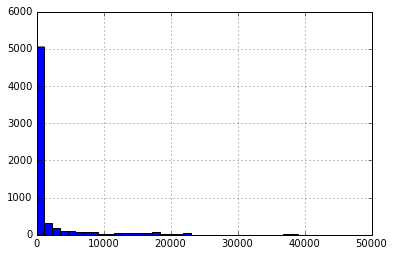

In [12]:
itemcount_df.num_patients.hist(bins=40)

A vast majority of itemids have just a few patients. Let's only focus on the itemids where there are lots of measurements.

We have two problems to solve:

1. Feature selection
2. Merging CareVue and Metavision databases
    - Different itemids for the same measurement
    - Different measurement units for the same measurement

The solutions:

1. I worked with a medical student (Sameh Saleh) to pick the top ~100 features that are important. 
2. Out of the top 100 features, we went through and manually matched different itemids and different measurement units. We looked at the most popular itemids and their labels in the d_items table. 

The resultant itemids are located in two files: 
- keep_items.txt: These are main items that we want
- item_map.json: A dictionary of all the itemids we want to map together. All the itemids in the values should be changed to match the key.

Before we match the itemids, we need to check to see if any units need to be transformed. 

Loading in item_map.json

In [ ]:
with open('item_map.json') as data_file:    
    item_map1 = json.load(data_file)

#jsons are a bit weird. We'll convert the keys to intergers. 
item_map = {}
for key, value in item_map1.iteritems():
    item_map[int(key)] = value

Checking the units in the "valueom" column from chartevents for every key/value combo

In [ ]:
item_units = {}
total = len(item_map)
count = 0
start_time = time.time()
for key, value in item_map.iteritems():
    count +=1 
    print '\r', count, time.time()- start_time, (time.time()- start_time)/count, 
    q_items = value + [key]
    item_str = ", ".join([str(item) for item in q_items])
    que = '''select valueuom from chartevents tablesample system(0.2) where itemid in (%s)''' % item_str
    item_units[key] = pd.read_sql(que, db)['valueuom'].unique()
    

18 560.68185091 31.1489959955

In [ ]:
for key, value in item_units.iteritems():
    if all(value): #checks if nonetype is in list or not
        if len(value) > 1:
            print key, value
    else:
        if len(value) > 2:
            print key, value

## Notes from my inspection

Need to investigate __639, 194, 223761, 218, 814, 223, 63, 141, 223835, 1534__
- 639 : ml/B looks like ml/breath. Should be the same
- 194 : has 224691 - really wierd distribution compared to 194, 195 (about 10x higher, but still have 0-10). dropping 224691 off of item_map for now.
- 223761 : all the temperatures. need to change C to F before merging. 
- 218 : the period probably means none. why am i spending my life on periods. 
- 814 : no diff between g/dl and gm/dl
- 223 : need to dissociate all with 223 ([669, 668, 667, 670, 671, 672]), they're all totally different units
- 63 : L/min, cmH2O, lpm seem to be the same.
    - Need to drop 68.
    - Spin off 63/227581 into their own (bpm) 
    - 65 needs to be its own thing too. 
    - for 63, dropping everything but 227581
    - making new id for 64, putting in 66, 67, 227579, 227580, 227582
- 141 : no diff
- 223835 : None and '%' units need to be converted. 'torr' unit ranges between 0.2 and 1, while None and % are from 20-100%... looks like we can convert 'Torr' (item 190) to just times *100*
- 1534 : can combine all

#### Summary: 
223835(torr) and 223761(temp) need conversion. All other dissociations were done along the way. 

Conversion strategy:
    1. Convert everything in 223835 and 223761 (convert values with different units)
    2. Change itemids for everything appropriately (match itemids in values to key)

To do the changes, we'll make a PSQL script to run, to change everything on the server side. I copied the PSQL code into a .psql file and ran it in the command line.

Here's the PSQL code for the unit conversion change:

update chartevents set valuenum=valuenum*9/5+32, valueuom='?F' where itemid=676 or itemid=223762;
update chartevents set valuenum=valuenum*100, valueuom='%' where itemid=190;

And to map the itemids

In [ ]:
for key, value in item_map.iteritems():
    for i in value:
        '''copy into buffer chart, change itemid, copy into ce, delete buffer chart'''
        print '''create table b_charts as select * from chartevents where itemid=%d;''' % i
        print '''update b_charts set itemid=%d;''' % key
        print '''insert into chartevents select * from b_charts;''' % key_chart
        print '''drop table b_charts;\n'''